Zachary Armand

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import Linear, ReLU, Sequential

In [3]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [4]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [5]:
input_values = torch.load('input_values.pth')
target_values = torch.load('target_values.pth')

Dataset and dataloaders are used for both models.

In [6]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.85, 0.15])
train_dataset, valid_dataset = random_split(train_dataset, [0.82, 0.18])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")

Train: 69.7%, Test: 15.0%, Valid: 15.3%


In [7]:
def train_model(model, optimizer, dataloader, device):
    model.train()
    criterion = nn.MSELoss()
    epoch_loss = 0
    for inputs, targets in dataloader:
        # Send to the right device
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)[:, 0]
        # Calculate and log loss
        loss = torch.sqrt(criterion(outputs, targets))
        # Backwards pass and step
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*inputs.size(0)  # loss * batch size
    return epoch_loss / len(dataloader.dataset)  # average loss 

def evaluate_model_RMSE(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Ensure test inputs are on the same device
            # Make prediction
            outputs = model(inputs)[:, 0]
            # Get loss
            loss = torch.sqrt(criterion(outputs, targets))  # sqrt(MSE)
            total_loss += loss.item()*inputs.size(0)  # loss * batch size
    return total_loss / len(dataloader.dataset)  # average loss

def evaluate_model_MAE(model, dataloader, device):
    model.eval()
    criterion = nn.L1Loss()
    total_loss = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Ensure test inputs are on the same device
            # Make prediction
            outputs = model(inputs)[:, 0]
            # Get loss
            loss = criterion(outputs, targets)  # MAE
            total_loss += loss.item()*inputs.size(0)  # loss * batch size
    return total_loss / len(dataloader.dataset)  # average loss

# Linear model

After hyperparameter tuning, the linear network hyperparameters are:
- Batch size: 64
- Learning rate: 0.001
- Dropout: 0.0
- L2 weight decay: 0.0

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, in_features=12, hidden_features=24, num_layers=3, dropout=0.0):
        super().__init__()
        
        layers = []        
        # Hidden layers (loop to create multiple layers)
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # Combine all layers into a sequential model
        self.mlpnet = nn.Sequential(
            # Input layer
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            # Loop of layers
            *layers,            
            # Output layer
            nn.Linear(hidden_features, 1)
        )

    def forward(self, x):
        x = self.mlpnet(x)
        return x.squeeze()

In [18]:
batch_size = 64
num_epochs = 200

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
simple_baseball_mlp = SimpleNet(hidden_features=48, num_layers=3, dropout=0.0).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = Adam(simple_baseball_mlp.parameters(), lr=0.0001, weight_decay=0.0)
loss_func = nn.MSELoss()

# Training
mlp_log = []
mlp_eval_log = []

# Training loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE)
    mlp_log.append(avg_train_loss)
    # Validation loss
    avg_valid_loss = evaluate_model_RMSE(simple_baseball_mlp, valid_dataloader, DEVICE)
    mlp_eval_log.append(avg_valid_loss)
    # Update progress bar
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})

# Final output
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# Evaluate model
test_accuracy_RMSE = evaluate_model_RMSE(simple_baseball_mlp, test_dataloader, DEVICE)
test_accuracy_MAE = evaluate_model_MAE(simple_baseball_mlp, test_dataloader, DEVICE)
print(f'Test RMSE: {test_accuracy_RMSE:.4f}, Test MAE: {test_accuracy_MAE:.4f}')

Trainable parameters: 7,729


Training MLP: 100%|██████████| 200/200 [07:34<00:00,  2.27s/it, Train loss=0.356, Validation loss=0.358]


Test RMSE: 0.3597, Test MAE: 0.2702


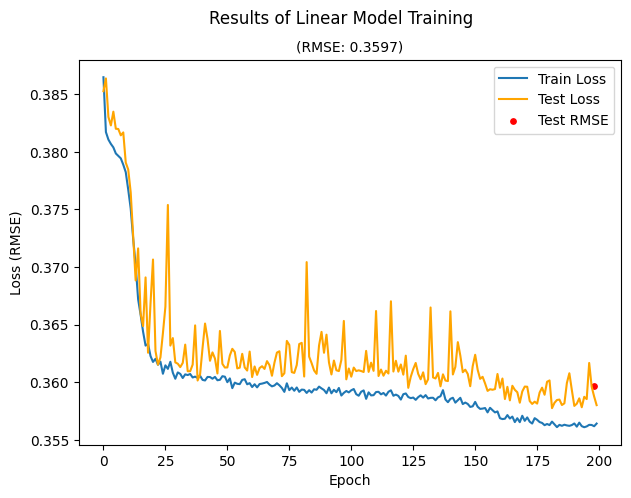

In [19]:
# Plot loss over time, final test stats
plt.figure(figsize=(7, 5))
plt.suptitle("Results of Linear Model Training")
plt.title(f"(RMSE: {test_accuracy_RMSE:.4})", size=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.plot(mlp_log, label='Train Loss')
plt.plot(mlp_eval_log, label='Test Loss', color='orange')
plt.scatter(x=epoch-1, y=test_accuracy_RMSE, color='r', label="Test RMSE", s=15)
plt.legend()
plt.show()

In [47]:
n_samples = 250  

real_ys = [dat[1].item() for i, dat in enumerate(dataset) if i < n_samples]
mlp_ys = [simple_baseball_mlp(dat[0].to(DEVICE)).item() for i, dat in enumerate(dataset) if i < n_samples]

plt.title("Residuals")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
sns.residplot(x=mlp_ys, y=real_ys)
plt.show()

RuntimeError: a Tensor with 8 elements cannot be converted to Scalar

# RNN model

After hyperparameter tuning, the RNN hyperparameters are:
- Batch size: 32
- GRU layers: 2
- Learning rate: 0.001
- Dropout: 0.5
- L2 weight decay: 0.0001

In [20]:
class BaseballRNN(torch.nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=256, n_layers=1, bidirectional=False, hidden_init='rand', rnn_dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.hidden_init = hidden_init
        self.rnn_dropout = rnn_dropout


        # Input fc layer
        self.fc_in = nn.Linear(input_size, self.hidden_size)
        # GRU Layer
        self.rnn1 = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True, num_layers=self.n_layers, dropout=self.rnn_dropout)
        # Dropout layer after last GRU layer
        self.layernorm = nn.LayerNorm(self.hidden_size)
        self.dropout = nn.Dropout(self.rnn_dropout)
        # Fully connected layer
        self.fc1 = nn.Linear(self.hidden_size, 64)  # fixed number of neurons in the linear layer
        # Output layer
        self.fc_out = nn.Linear(64, output_size) 
        
        # RELU
        self.relu = nn.ReLU()

    def _init_hidden(self, batch_size, device):
        """Initialize the hidden state for the GRU."""
        if self.hidden_init == 'zero':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'rand':
            h0 = torch.randn(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'xavier':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
            nn.init.xavier_uniform_(h0)
        else:
            raise ValueError(f"Unsupported hidden_init: {self.hidden_init}")
        return h0

    def forward(self, x):      
        # Initial hidden states for RNNs
        h0 = self._init_hidden(x.size(0), x.device)

        # Pre RNN Linear Layer
        x = self.relu(self.fc_in(x))

        # Send through RNN 
        residual = x
        out, hidden = self.rnn1(x, h0)
        out = out + residual  # Residual connection
        # Get output of the last time step
        out = out[:, -1, :]  # (batch_size, seq_len, hidden_size)
        out = self.layernorm(out)
        out = self.dropout(out)

        # Send through fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)

        # Output layer
        out = self.fc_out(out)

        return out

In [21]:
batch_size = 32
num_epochs = 200

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
input_size = train_dataloader.dataset[0][0].size()[1]
baseball_rnn = BaseballRNN(input_size=input_size, output_size=1, hidden_size=24,
                                n_layers=2, hidden_init='xavier', rnn_dropout=0.5).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in baseball_rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = Adam(baseball_rnn.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.MSELoss()

# Training
rnn_log = []
rnn_eval_log = []

# Training loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(baseball_rnn, optimizer, train_dataloader, DEVICE)
    rnn_log.append(avg_train_loss)
    # Validation loss
    avg_valid_loss = evaluate_model_RMSE(baseball_rnn, valid_dataloader, DEVICE)
    rnn_eval_log.append(avg_valid_loss)
    # Update progress bar
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})

# Final output
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# Evaluate model
test_accuracy_RMSE = evaluate_model_RMSE(baseball_rnn, test_dataloader, DEVICE)
test_accuracy_MAE = evaluate_model_MAE(baseball_rnn, test_dataloader, DEVICE)
print(f'Test RMSE: {test_accuracy_RMSE:.4f}, Test MAE: {test_accuracy_MAE:.4f}')

Trainable parameters: 9,225


Training MLP: 100%|██████████| 200/200 [19:35<00:00,  5.88s/it, Train loss=0.377, Validation loss=0.379]


Test RMSE: 0.3805, Test MAE: 0.2924


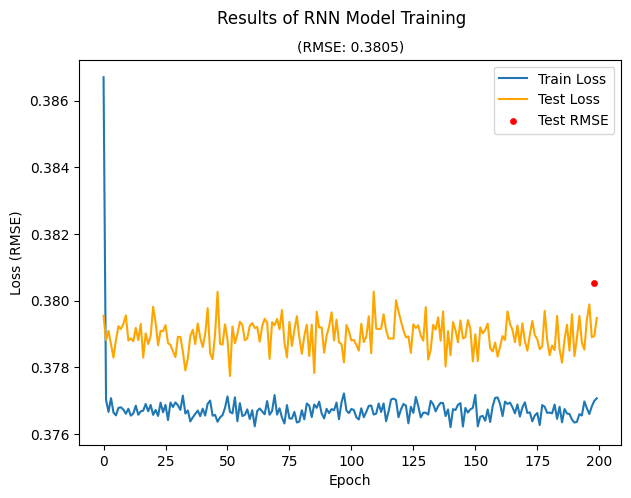

In [22]:
# Plot loss over time, final test stats
plt.figure(figsize=(7, 5))
plt.suptitle("Results of RNN Model Training")
plt.title(f"(RMSE: {test_accuracy_RMSE:.4})", size=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.plot(rnn_log, label='Train Loss')
plt.plot(rnn_eval_log, label='Test Loss', color='orange')
plt.scatter(x=epoch-1, y=test_accuracy_RMSE, color='r', label="Test RMSE", s=15)
plt.legend()
plt.show()

### The two models

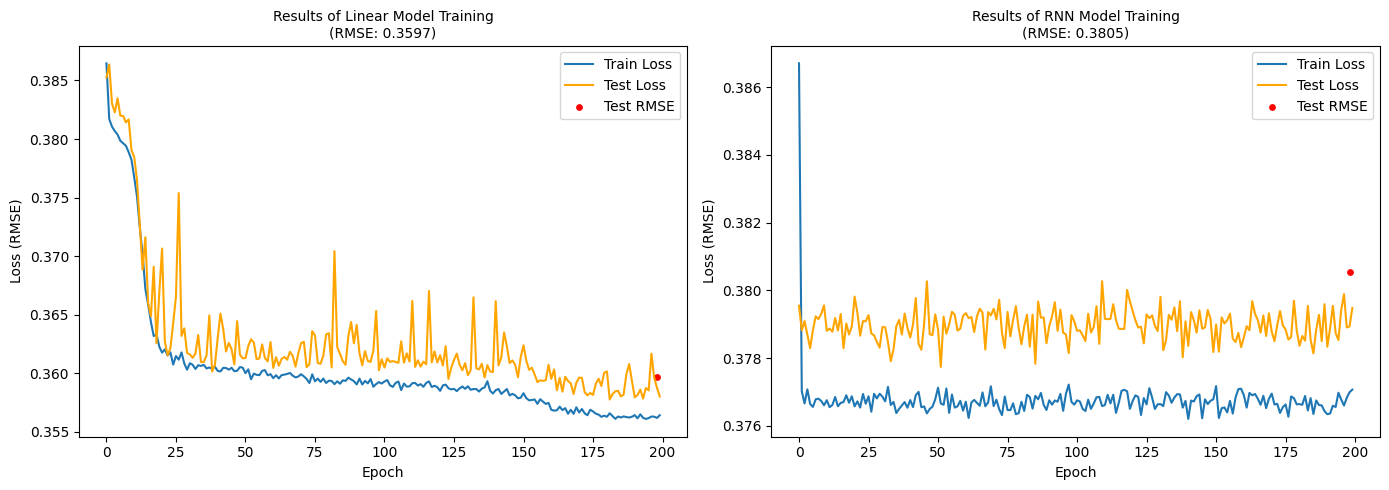

In [27]:
# Create a figure and axis objects for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot for the Linear Model Training
ax[0].set_title(f"Results of Linear Model Training\n(RMSE: {0.3597:.4})", fontsize=10)
ax[0].set_ylabel('Loss (RMSE)')
ax[0].set_xlabel('Epoch')
ax[0].plot(mlp_log, label='Train Loss')
ax[0].plot(mlp_eval_log, label='Test Loss', color='orange')
ax[0].scatter(x=epoch-1, y=0.3597, color='r', label="Test RMSE", s=15)
ax[0].legend()

# Plot for the RNN Model Training
ax[1].set_title(f"Results of RNN Model Training\n(RMSE: {test_accuracy_RMSE:.4})", fontsize=10)
ax[1].set_ylabel('Loss (RMSE)')
ax[1].set_xlabel('Epoch')
ax[1].plot(rnn_log, label='Train Loss')
ax[1].plot(rnn_eval_log, label='Test Loss', color='orange')
ax[1].scatter(x=epoch-1, y=test_accuracy_RMSE, color='r', label="Test RMSE", s=15)
ax[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()
